In [3]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

In [4]:
def unpacker(df, key, num_exp=3, num_rounds=300, idx=0):
    result = []

    for i in range(num_rounds):
        single_elem = []
        for j in range(num_exp):
            single_elem.append(list(df[key])[j * (num_rounds * num_exp) + i * 3 + idx])
        # print(single_elem)
        # single_elem = round(sum(single_elem)/num_exp, 3)
        result.append(single_elem)
    result = torch.Tensor(result)
    mean = result.mean(dim=1)
    under = mean - result.std(dim=1)
    upper = mean + result.std(dim=1)

    mean, under, upper = mean.tolist(), under.tolist(), upper.tolist()
    return mean, under, upper

In [5]:
def plotter():
    p0 = f'./log/gihun/cifar_extreme_reverse/[cifarcnn-cifar10]extreme_reverse_noniid_095/results.csv'
    p1 = f'./log/gihun/cifar_extreme_reverse/[cifarcnn-cifar10]extreme_reverse_noniid_099/results.csv'
    p2 = f'./log/gihun/cifar_extreme_reverse/[cifarcnn-cifar10]baseline/results.csv'
    
    df0, df1 = pd.read_csv(p0), pd.read_csv(p1)
    df2 = pd.read_csv(p2)
    
    cost0, cost1, cost2 = unpacker(df0, 'Cost'), unpacker(df1, 'Cost'), unpacker(df2, 'Cost')
    sparsity0, sparsity1, sparsity2 = unpacker(df0, 'sparsity'), unpacker(df1, 'sparsity'), unpacker(df2, 'sparsity')
    acc0, acc1, acc2 = unpacker(df0, 'ACC', idx=2), unpacker(df1, 'ACC', idx=2), unpacker(df2, 'ACC', idx=2)
    tr_loss0, tr_loss1, tr_loss2 = unpacker(df0, 'Loss', idx=0), unpacker(df1, 'Loss', idx=0), unpacker(df2, 'Loss', idx=0)
    te_loss0, te_loss1, te_loss2 = unpacker(df0, 'Loss', idx=1), unpacker(df1, 'Loss', idx=1), unpacker(df2, 'Loss', idx=1)
    
    rounds = [x + 1 for x in range(300)]
    
    
    fig = plt.figure(figsize=(8, 6))
    plt.yticks([10 * x for x in range(10)], fontsize=15)
    plt.xticks([50 * x for x in range(7)], fontsize=15)

    
    plt.plot(rounds, acc2[0], label='baseline', lw=2, color='gray', alpha=1)
    plt.fill_between(rounds, acc2[1], acc2[2], color='gray', alpha=0.2)

    plt.plot(rounds, acc0[0], label='FedWR(95%)', lw=2, color='orange', alpha=1)
    plt.fill_between(rounds, acc0[1], acc0[2], color='orange', alpha=0.1)

    plt.plot(rounds, acc1[0], label='FedWR(99%)', lw=2, color='orangered', alpha=1)
    plt.fill_between(rounds, acc1[1], acc1[2], color='orangered', alpha=0.2)

    # plt.plot(, label='Pruning', lw=5, color='blue')
    plt.xlabel('Round', fontsize=20)
    plt.ylabel('Accuracy (%)', fontsize=20)
    plt.xlim(0, 300)
    plt.ylim(0, 70)
    plt.legend(fontsize=18, loc='lower right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    
    
    fig = plt.figure(figsize=(8, 6))
    plt.yticks([10 * x for x in range(10)], fontsize=15)
    plt.xticks([4000 * x for x in range(7)], fontsize=15)

    
    plt.plot(cost2[0], acc2[0], label='baseline', lw=2, color='gray', alpha=1)
    plt.fill_between(cost2[0], acc2[1], acc2[2], color='gray', alpha=0.2)

    plt.plot(cost0[0], acc0[0], label='FedWR(95%)', lw=2, color='orange', alpha=1)
    plt.fill_between(cost0[0], acc0[1], acc0[2], color='orange', alpha=0.1)

    plt.plot(cost1[0], acc1[0], label='FedWR(99%)', lw=2, color='orangered', alpha=1)
    plt.fill_between(cost1[0], acc1[1], acc1[2], color='orangered', alpha=0.2)

    # plt.plot(, label='Pruning', lw=5, color='blue')
    plt.xlabel('Cost(MB)', fontsize=20)
    plt.ylabel('Accuracy (%)', fontsize=20)
    plt.xlim(0, 21600)
    plt.ylim(0, 70)
    plt.legend(fontsize=18, loc='lower right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    
    
    fig = plt.figure(figsize=(8, 6))
    plt.yticks([0.5 * y for y in range(11)], fontsize=15)
    plt.xticks([4000 * x for x in range(7)], fontsize=15)

    
    plt.plot(cost2[0], te_loss2[0], label='baseline', lw=2, color='gray', alpha=1)
    plt.fill_between(cost2[0], te_loss2[1], te_loss2[2], color='gray', alpha=0.1)
    plt.plot(cost2[0], tr_loss2[0], lw=2, color='gray', alpha=0.5, linestyle='--')

    plt.plot(cost0[0], te_loss0[0], label='FedWR(95%)', lw=2, color='orange', alpha=1)
    plt.fill_between(cost0[0], te_loss0[1], te_loss0[2], color='orange', alpha=0.1)
    plt.plot(cost0[0], tr_loss0[0], lw=2, color='orange', alpha=0.5, linestyle='--')

    # Local Pruning
    plt.plot(cost1[0], te_loss1[0], label='FedWR(99%)', lw=2, color='orangered', alpha=1)
    plt.fill_between(cost1[0], te_loss1[1], te_loss1[2], color='orangered', alpha=0.1)
    plt.plot(cost1[0], tr_loss1[0], lw=2, color='orangered', alpha=0.5, linestyle='--')


    # plt.plot(, label='Pruning', lw=5, color='blue')
    plt.xlabel('Cost(MB)', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xlim(0, 21600)
    plt.ylim(0, 3)
    plt.legend(fontsize=18, loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()


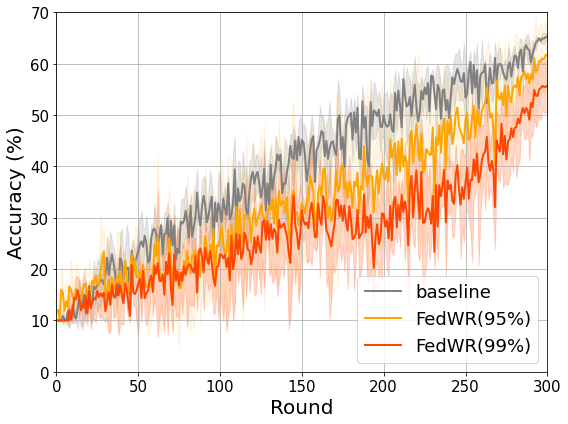

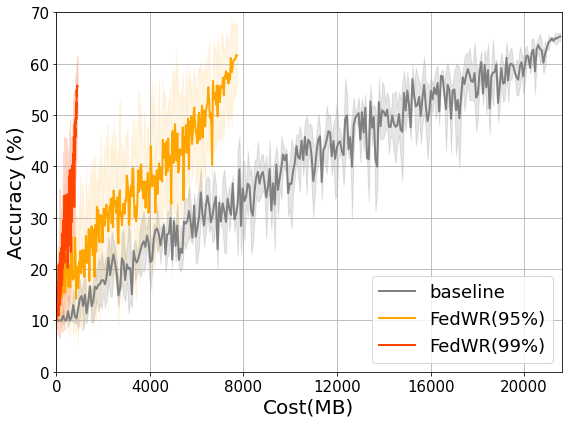

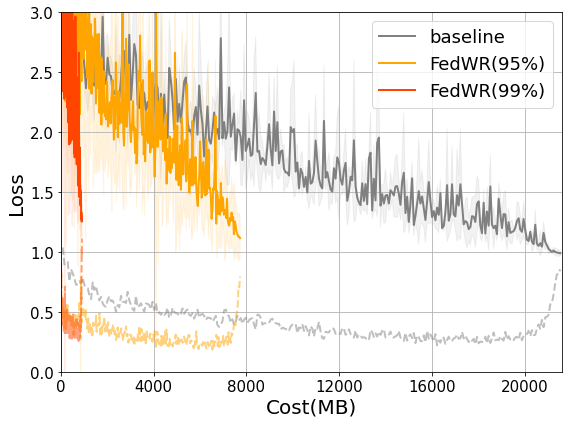

In [6]:
plotter()